In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [2]:
import numpy as np
import matplotlib.pyplot as plt                        
import torch
import pandas as pd
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# Define parameters

In [3]:
THRESHOLD = 1
NUM_EPOCHS = 200




In [4]:
# CNN params
w = 45
pred_window = 1
filter1_size = 128
filter2_size = 32
kernel_size = 2
stride = 1
pool_size = 2



# Define CNN architechture

In [5]:
#  CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        ## layers of a CNN
        
        self.conv1 = nn.Conv1d(1,filter1_size,kernel_size,stride,padding = 0)
        
        self.conv2 = nn.Conv1d(filter1_size,filter2_size,kernel_size,stride,padding = 0)

        self.maxpool = nn.MaxPool1d(pool_size)
        
        self.dim1 = int(0.5*(0.5*(w-1)-1)) * filter2_size
        
        self.lin1 = nn.Linear(self.dim1,pred_window )

        self.dropout = nn.Dropout(0.25)
    
    def forward(self, x):
        #convolution layer 1
        x = (F.relu(self.conv1(x)))
        x = self.maxpool(x)
        
        #convolution layer 2
        x = (F.relu(self.conv2(x)))
        x = self.maxpool(x)

        x = x.view(-1,self.dim1)
        
        x = self.dropout(x)
        x = self.lin1(x)

        return x
    
    

# Define helper functions

In [6]:
def get_subsequences(data):
    X = []
    Y = []
    
    for i in range(len(data) - w - pred_window):
        X.append(data[i : i + w])
        Y.append(data[i + w : i + w + pred_window])
    
    X = np.array(X)
    Y = np.array(Y)
    
    X = np.reshape(X, (X.shape[0], 1, X.shape[1]))
    
    return X, Y



In [7]:
def train_valid(n_epochs, trainX, trainY, validX, validY, model, optimizer, criterion, save_path, freq=20):
    """returns trained model"""

    target_train = torch.tensor(trainY).type('torch.FloatTensor')
    data_train = torch.tensor(trainX).type('torch.FloatTensor')
    
    target_valid = torch.tensor(validY).type('torch.FloatTensor')
    data_valid = torch.tensor(validX).type('torch.FloatTensor')
    
    train_loss_min = np.Inf
    valid_loss_min = np.Inf
    last_valid_loss= 0
    
    for epoch in range(1, n_epochs+1):
        
        ############
        # training #
        ############
        model.train()

        optimizer.zero_grad()
        output = model(data_train)
        loss = criterion(output, target_train)
        loss.backward()
        optimizer.step()
        train_loss = loss.item()
        
        ##############
        # validation #
        ##############
        model.eval()
        output_valid = model(data_valid)
        
        loss_valid = criterion(output_valid, target_valid)
        valid_loss = loss_valid.item()
        
        if(valid_loss == last_valid_loss):
            print('problem')
            
        last_valid_loss = valid_loss
        if(epoch%freq == 0):
            print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
                epoch, 
                train_loss,
                valid_loss
                ), end='\r')
            
        # save model if validation loss decreases
        if valid_loss < valid_loss_min:
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss

    return model,output




In [8]:
def calc_f_score(ts_data, df_out, thresh):
    positives = ts_data.loc[df_out.index].loc[ts_data.is_anomaly == 1].index
    negatives = ts_data.loc[df_out.index].loc[ts_data.is_anomaly == 0].index

    tp = []
    fn = []
    fp = []
    tn = []
    for p in positives:
        if p in thresh.index:
            tp.append(p)
        else:
            fn.append(p)

    for n in negatives:
        if n in thresh.index:
            fp.append(n)
        else:
            tn.append(n)
            
    recall = len(tp) / (len(tp) + len(fn))
    
    if recall != 0:
        precision = len(tp) / (len(tp) + len(fp))
        F_score = 2 * recall * precision / (recall + precision)
    else:
        F_score = 0
    
    #precision = len(tp) / (len(tp) + len(fp))
    #F_score = 2 * recall * precision / (recall + precision)
    
    return F_score

In [9]:
# main function to fit model, predict anomalies and calc score
def calc_model_performance(filename):
    # load dataset from file
    ts_data = pd.read_csv(filename, index_col = 0)

    # separate test and train
    train_percent = int(0.3 * len(ts_data))
    valid_percent = int(0.1 * len(ts_data))
    test_percent = int(0.6 * len(ts_data))

    train_data = list(ts_data.iloc[:train_percent,0])
    valid_data = list(ts_data.iloc[train_percent:train_percent + valid_percent,0])
    test_data = list(ts_data.iloc[train_percent + valid_percent:,0])

    trainX, trainY = get_subsequences(train_data)
    validX, validY = get_subsequences(valid_data)
    testX, testY = get_subsequences(test_data)

    # specify and fit model
    model = Net()

    criterion_scratch = nn.L1Loss()
    optimizer_scratch = optim.Adam(model.parameters(), lr=1e-4, weight_decay=1e-6)

    # train model
    model, out = train_valid(NUM_EPOCHS, trainX, trainY, validX, validY, model, optimizer_scratch, 
                             criterion_scratch, 'model.pt', freq = 10)

    # load best saved model
    model.load_state_dict(torch.load('model.pt'));

    # predict value
    test_tensor =  torch.tensor(testX).type('torch.FloatTensor')

    model.eval()

    out = model(test_tensor)
    out = out.detach().numpy()

    df_out = pd.DataFrame()
    df_out['pred'] = out[:, 0]
    df_out['actual'] = testY[:, 0]

    # predict anomalies
    df_out['error'] = np.abs(df_out['pred'] - df_out['actual'])
    df_out['error_n'] = (df_out['error'] - df_out['error'].mean()) / df_out['error'].std()
    df_out.index = ts_data.index[train_percent + valid_percent + w + pred_window - 1 : -1]

    thresh = df_out.loc[df_out['error_n'].abs() > THRESHOLD]
    
    # no fscore is calculated as this is unsupervised data
    
    return thresh #,f_score


In [10]:
# reading the flashcrash data extracted from ITCH site and preporrocessing it 
# and converting it to a mid price time series
flashcrash=pd.read_csv("FLASH_CRASH.csv")

# cleaing up the column names
cols = []
for col in flashcrash.columns:
    col = col.replace("TVITCH_41::SPY.", "")
    col = col.replace("..TVITCH_41__HPE", "")
    cols.append(col)

flashcrash.columns = cols

flashcrash["Time"] = pd.to_datetime( flashcrash["Time"])

# calculating the midprice and choosing just the best ask and best bid
flashcrash["Mid"] = flashcrash["ASK_PRICE"]/2 + flashcrash["BID_PRICE"]/2 
flashcrash = flashcrash[flashcrash["LEVEL"] == 1]
flashcrash.head()

,Index,Time,BID_PRICE,BID_UPDATE_TIME,BID_SIZE,ASK_PRICE,ASK_UPDATE_TIME,ASK_SIZE,LEVEL,Mid
0,1,2010-05-06 09:30:05,116.30,2010/05/06 09:30:04.927,3520,116.31,2010/05/06 09:30:04.926,3700,1,116.305
10,11,2010-05-06 09:30:10,116.36,2010/05/06 09:30:09.971,6946,116.37,2010/05/06 09:30:09.992,2839,1,116.365
20,21,2010-05-06 09:30:15,116.34,2010/05/06 09:30:14.807,6673,116.36,2010/05/06 09:30:14.907,8800,1,116.350
30,31,2010-05-06 09:30:20,116.35,2010/05/06 09:30:19.996,700,116.36,2010/05/06 09:30:19.994,10243,1,116.355
40,41,2010-05-06 09:30:25,116.38,2010/05/06 09:30:24.969,2521,116.39,2010/05/06 09:30:24.976,8050,1,116.385


In [11]:
flashcrash["Mid"]

0        116.305
10       116.365
20       116.350
30       116.355
40       116.385
          ...   
46750    113.005
46760    112.975
46770    112.995
46780    112.980
46790    112.880
Name: Mid, Length: 4680, dtype: float64

In [12]:
# saving the converted timeseries data
flashcrash.loc[:,["Time","Mid"]].to_csv("flash_ts.csv",index=False)

In [13]:
ts_data = pd.read_csv("flash_ts.csv", index_col = 0)
ts_data 

,Mid
Time,
2010-05-06 09:30:05,116.305
2010-05-06 09:30:10,116.365
2010-05-06 09:30:15,116.350
2010-05-06 09:30:20,116.355
2010-05-06 09:30:25,116.385
...,...
2010-05-06 15:59:40,113.005
2010-05-06 15:59:45,112.975
2010-05-06 15:59:50,112.995


In [14]:
thresh = calc_model_performance("flash_ts.csv")


In [15]:
thresh

,pred,actual,error,error_n
Time,,,,
2010-05-06 14:39:55,112.524452,111.855,0.669452,1.033706
2010-05-06 14:40:05,112.517410,111.855,0.662410,1.016503
2010-05-06 14:40:10,112.502831,111.845,0.657831,1.005316
2010-05-06 14:40:15,112.484459,111.775,0.709459,1.131438
2010-05-06 14:40:20,112.458656,111.735,0.723656,1.166120
...,...,...,...,...
2010-05-06 15:48:50,113.172173,114.005,0.832827,1.432813
2010-05-06 15:48:55,113.195282,113.970,0.774718,1.290858
2010-05-06 15:49:00,113.215500,113.990,0.774500,1.290326


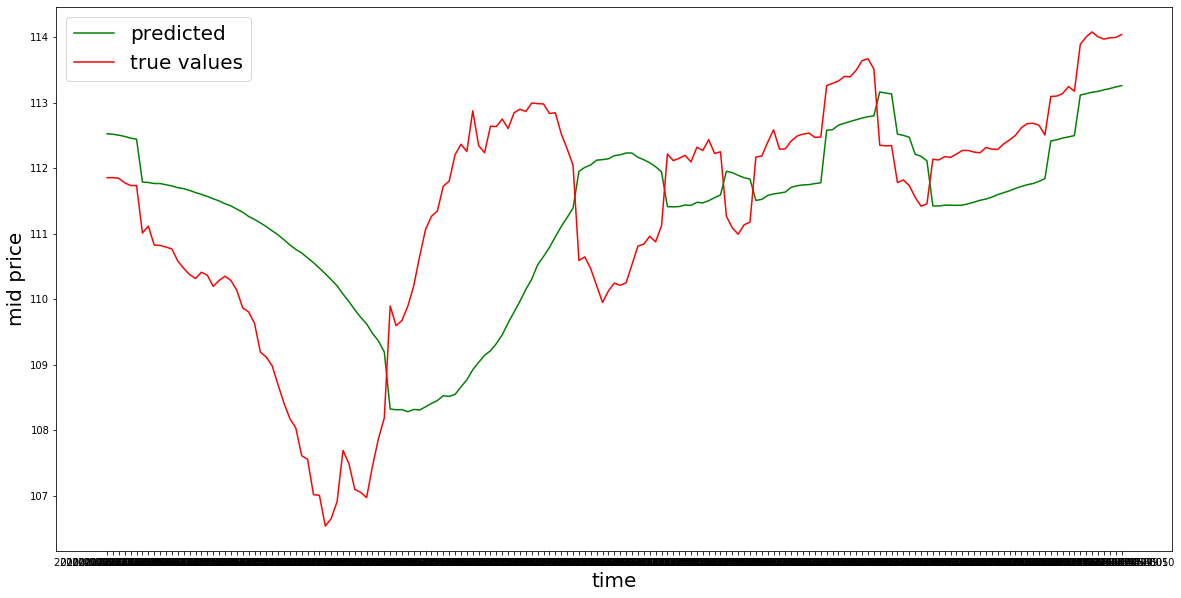

In [16]:
# plottong predicted and rue values and saving the plot
plt.figure(figsize=(20,10))
plt.plot(thresh["pred"],"g",thresh["actual"],"r")
plt.xlabel("time", fontsize = 20)
plt.ylabel("mid price",fontsize = 20)
plt.legend(["predicted","true values"], fontsize = 20)
plt.savefig("flashcrash_predvsrtue.png")

In [17]:
thresh

,pred,actual,error,error_n
Time,,,,
2010-05-06 14:39:55,112.524452,111.855,0.669452,1.033706
2010-05-06 14:40:05,112.517410,111.855,0.662410,1.016503
2010-05-06 14:40:10,112.502831,111.845,0.657831,1.005316
2010-05-06 14:40:15,112.484459,111.775,0.709459,1.131438
2010-05-06 14:40:20,112.458656,111.735,0.723656,1.166120
...,...,...,...,...
2010-05-06 15:48:50,113.172173,114.005,0.832827,1.432813
2010-05-06 15:48:55,113.195282,113.970,0.774718,1.290858
2010-05-06 15:49:00,113.215500,113.990,0.774500,1.290326


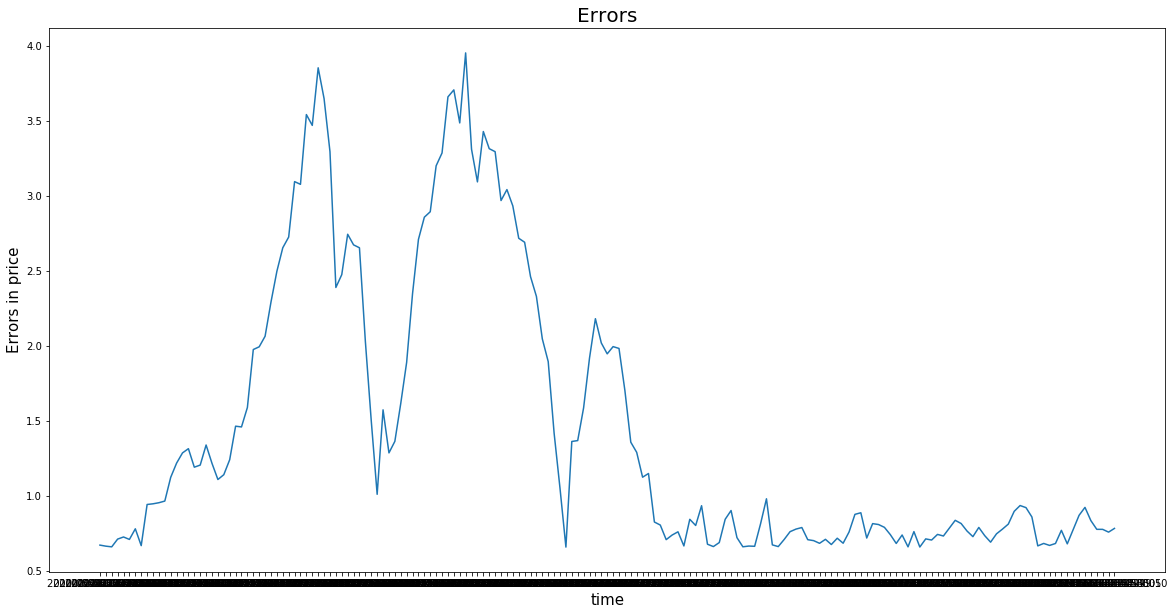

In [18]:
# plotting the errors
plt.figure(figsize=(20,10))
plt.plot(thresh["error"])
plt.title("Errors",fontsize = 20)
plt.xlabel("time", fontsize = 15)
plt.ylabel("Errors in price", fontsize = 15)
plt.savefig("flashcrash_errors.png")


In [19]:
# checking the time and points with the highest errors( or most anomalous)
thresh.sort_values(by = "error", ascending=False)[:15]


,pred,actual,error,error_n
Time,,,,
2010-05-06 14:48:35,108.922211,112.875,3.952789,9.054514
2010-05-06 14:45:40,110.388390,106.535,3.853390,8.811692
2010-05-06 14:48:25,108.658905,112.365,3.706095,8.451869
2010-05-06 14:48:20,108.545547,112.205,3.659453,8.337927
2010-05-06 14:45:45,110.298103,106.650,3.648103,8.310202
2010-05-06 14:45:30,110.556458,107.015,3.541458,8.049679
2010-05-06 14:48:30,108.769310,112.255,3.485690,7.913445
2010-05-06 14:45:35,110.474220,107.005,3.469220,7.873212
2010-05-06 14:48:50,109.211662,112.640,3.428338,7.773340
